In [1]:
import gc
import logging
import pickle
import sys
import warnings
from pathlib import Path

import numpy as np
import optuna
import pandas as pd
from catboost import CatBoostClassifier, Pool
from dataset import Dataset
from metrics import metrics_estimation
from optuna.integration import CatBoostPruningCallback
from optuna.pruners import SuccessiveHalvingPruner
from scipy.stats import uniform
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from xgboost import XGBClassifier

from lightgbm import LGBMClassifier, early_stopping

RAND = 0
N_FOLDS = 5
warnings.filterwarnings("ignore")

# Data Import, Preprocessing

In [ ]:
ds = Dataset()
df_train = ds.get_dataframe()

In [3]:
X = df_train.to_pandas()
X.set_index("case_id", inplace=True)
del df_train

In [4]:
weeks = X.pop("WEEK_NUM")
y = X.pop("target")
X

month_decision  weekday_decision  days30_165L  maritalst_385M  \
case_id                                                                    
0.0                     1                 4          NaN             NaN   
1.0                     1                 4          NaN             NaN   
2.0                     1                 5          NaN             NaN   
3.0                     1                 4          NaN             NaN   
4.0                     1                 5          NaN             NaN   
...                   ...               ...          ...             ...   
2703450.0              10                 1          0.0             2.0   
2703451.0              10                 1          0.0             2.0   
2703452.0              10                 1          0.0             2.0   
2703453.0              10                 1          1.0             0.0   
2703454.0              10                 1          0.0             4.0   

           pmtscount_423L requesttype_4525192L  annuity_780A  \
case_id                                                        
0.0                   NaN                 None     1917.6000   
1.0                   NaN                 None     3134.0000   
2.0                   NaN                 None     4937.0000   
3.0                   NaN                 None     4643.6000   
4.0                   NaN                 None     3390.2000   
...                   ...                  ...           ...   
2703450.0             NaN                 None     3675.4001   
2703451.0             NaN                 None     7088.6000   
2703452.0             NaN                 None     7788.8003   
2703453.0             NaN                 None     1195.4000   
2703454.0             NaN                 None     4533.8003   

           annuitynextmonth_57A  avginstallast24m_3658937A  \
case_id                                                      
0.0                         0.0                        NaN   
1.0                         0.0                        NaN   
2.0                         0.0                        NaN   
3.0                         0.0                        NaN   
4.0                         0.0                        NaN   
...                         ...                        ...   
2703450.0                   0.0                  7356.8003   
2703451.0                6191.6                 12553.2000   
2703452.0                   0.0                  2662.4001   
2703453.0                2827.2                  8212.6010   
2703454.0                2986.8                  6405.4000   

           avgoutstandbalancel6m_4187114A  ...  purposeofcred_active  \
case_id                                    ...                         
0.0                                   NaN  ...                  None   
1.0                                   NaN  ...                  None   
2.0                                   NaN  ...                  None   
3.0                                   NaN  ...                  None   
4.0                                   NaN  ...                  None   
...                                   ...  ...                   ...   
2703450.0                       16392.496  ...              a55475b1   
2703451.0                      105129.310  ...              a55475b1   
2703452.0                             NaN  ...              a55475b1   
2703453.0                       47943.062  ...              a55475b1   
2703454.0                       15651.796  ...              a55475b1   

           residualamount_closed  subjectrole_active subjectrole_closed  \
case_id                                                                   
0.0                          NaN                None               None   
1.0                          NaN                None               None   
2.0                          NaN                None               None   
3.0                          NaN                None               Non

In [5]:
cat_features = X.select_dtypes(exclude=np.number).columns.tolist()
num_features = X.select_dtypes(include=np.number).columns.tolist()
len(num_features) + len(cat_features)

190

Заполним пропуски в категориальных данных значением 'None'.

In [6]:
imputer_cat = SimpleImputer(missing_values=None, strategy="constant", fill_value="None")
X[cat_features] = imputer_cat.fit_transform(X[cat_features], y)

In [7]:
X[cat_features] = X[cat_features].astype("category")

In [8]:
X_train, X_test, y_train, y_test, weeks_train, weeks_test = train_test_split(
    X, y, weeks, test_size=0.2, stratify=y, shuffle=True, random_state=RAND
)

X_train_, X_val, y_train_, y_val, weeks_train_, weeks_val = train_test_split(
    X_train,
    y_train,
    weeks_train,
    test_size=0.16,
    stratify=y_train,
    shuffle=True,
    random_state=RAND,
)
scale_pos_weight = float(np.sum(y_train_ == 0)) / np.sum(y_train_ == 1)

Далее обучим baseline модели CatBoost, LightGBM и XGBoost. Найдем лучшие гиперпараметры с помощью optuna.

# CatBoost

## Baseline

In [106]:
eval_set = [(X_val, y_val)]
clf_baseline = CatBoostClassifier(
    eval_metric="CrossEntropy",
    random_state=RAND,
    scale_pos_weight=scale_pos_weight,
    cat_features=cat_features,
    task_type="GPU",
)

In [107]:
clf_baseline.fit(
    X_train_, y_train_, eval_set=eval_set, early_stopping_rounds=100, verbose=0
);

In [108]:
metrics = metrics_estimation(
    clf_baseline,
    X_train_,
    y_train_,
    X_test,
    y_test,
    weeks_train_,
    weeks_test,
    name="CatBoost_Baseline",
)
metrics

Accuracy   ROC_AUC  Precision    Recall        f1  \
model                                                                        
CatBoost_Baseline_train  0.770459  0.874301   0.103364  0.821096  0.183614   
CatBoost_Baseline_test   0.769602  0.853037   0.098587  0.777164  0.174978   

                          Logloss  gini_stability  overfitting, %  
model                                                              
CatBoost_Baseline_train  0.460291        0.730205        2.492725  
CatBoost_Baseline_test   0.463039        0.674862        2.492725

## Optuna

Определим параметры для оптимального обучения catboost на GPU.

In [109]:
static_params_catboost = {
    "eval_metric": "AUC",
    "boosting_type": "Plain",
    "border_count": 32,
    "task_type": "GPU",
    "od_wait": 20,
}

In [9]:
def get_pruner(path: str) -> SuccessiveHalvingPruner:
    """
    Load from file or create new pruner if not exists.

    Parameters
    ----------
    path: str
        to pruner file

    Returns
    -------
    out : SuccessiveHalvingPruner
    """
    pruner_file = Path(path)
    if pruner_file.exists():
        return pickle.load(open(path, "rb"))
    else:
        return SuccessiveHalvingPruner()

In [11]:
def get_train_data(
    X: pd.DataFrame, y: pd.Series, weeks: pd.Series, frac: float = 1.0
) -> dict:
    """
    Returns a random sample of dataset with fraction frac if frac < 1.

    Parameters
    ----------
    X: pd.DataFrame
        X_train to split into X_train_cv and X_val_cv
    y: pd.Series
        y_train to split into y_train_cv and y_val_cv
    weeks: pd.Series
        For StratifiedGroupKFold as groups
    frac: float
        Fraction of axis items to return.

    Returns
    -------
    out : dict
        Sampled X, y, weeks
    """
    if frac == 1.0:
        return {"X": X, "y": y, "weeks": weeks}
    else:
        X_sample = X.sample(frac=frac)
        idx = X_sample.index
        y_sample, weeks_sample = y.loc[idx], weeks.loc[idx]
        return {"X": X_sample, "y": y_sample, "weeks": weeks_sample}

In [36]:
def objective(
    trial: optuna.trial.Trial, X: pd.DataFrame, y: pd.Series, weeks: pd.Series
) -> float:
    """
    Optimization objective function for CatBoost model with cross-validation.

    Parameters
    ----------
    trial : optuna.trial.Trial
       instance represents a process of evaluating an objective function
    X: pd.DataFrame
        X_train to split into X_train_cv and X_val_cv
    y: pd.Series
        y_train to split into y_train_cv and y_val_cv
    weeks: pd.Series
        For StratifiedGroupKFold as groups

    Returns
    -------
    out : float
       mean ROC_AUC
    """
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [2000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.04, 0.14),
        "max_depth": trial.suggest_int("max_depth", 6, 16),
        "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-4, 1e4),
        "random_strength": trial.suggest_uniform("random_strength", 0.01, 1e4),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "No", "Poisson"]
        ),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]
        ),
        "leaf_estimation_iterations": trial.suggest_int(
            "leaf_estimation_iterations", 2, 64
        ),
    }
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 1000
        )
    elif params["bootstrap_type"] in ["Poisson", "Bernoulli"]:
        params["subsample"] = trial.suggest_float("subsample", 0.01, 1.0, log=True)

    cv = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True)
    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=weeks)):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        train_data = Pool(data=X_train_cv, label=y_train_cv, cat_features=cat_features)
        eval_data = Pool(data=X_val_cv, label=y_val_cv, cat_features=cat_features)
        model = CatBoostClassifier(
            random_state=RAND,
            scale_pos_weight=scale_pos_weight,
            cat_features=cat_features,
            use_best_model=True,
            **params,
            **static_params_catboost,
        )
        model.fit(train_data, eval_set=eval_data, early_stopping_rounds=100, verbose=0)

        y_pred = model.predict(X_val_cv)
        y_score = model.predict_proba(X_val_cv)
        cv_predicts[idx] = roc_auc_score(y_val_cv, y_score[:, 1])
        trial.report(cv_predicts[idx], idx)
        print(f"Fold {idx} ROC AUC = {cv_predicts[idx]:.4f}")
        if trial.should_prune():
            raise optuna.TrialPruned()

    av_auc = np.mean(cv_predicts)
    print(f"Average ROC AUC on validation data (OOF): {av_auc:.4f}")
    return av_auc

In [37]:
def holdout_test(
    train_data: Pool, eval_data: Pool, X_test: pd.DataFrame, **final_params: dict
) -> float:
    """
    Train Catboost on best_params from trial. Estimate ROC AUC on holdout test data.

    Parameters
    ----------
    train_data : Pool
        X_train_ + y_train_
    eval_data: Pool
        X_val + y_val
    X_test: pd.DataFrame
        holdout test data
    final_params: dict
        For StratifiedGroupKFold as groups

    Returns
    -------
    out : float
       ROC_AUC on holdout test data
    """
    model = CatBoostClassifier(
        random_state=RAND,
        scale_pos_weight=scale_pos_weight,
        cat_features=cat_features,
        use_best_model=True,
        **final_params,
        **static_params_catboost
    )
    model.fit(
        train_data, eval_set=eval_data, plot=True, verbose=0, early_stopping_rounds=100
    )
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, y_score[:, 1])
    print("ROC AUC on Test holdout data: %s" % auc_test)
    return auc_test

In [ ]:
gc.collect()

study_name = "cat_boost3"
pruner_name = "pruner.pkl"
storage_name = "sqlite:///{}.db".format(study_name)

# Save the pruner with pickle to be loaded later.
if not Path(pruner_name).exists():
    pruner = get_pruner(pruner_name)
    with open(pruner_name, "wb") as fout:
        pickle.dump(pruner, fout)

study = optuna.create_study(
    storage_name,
    pruner=get_pruner(pruner_name),
    study_name=study_name,
    direction="maximize",
    load_if_exists=True,
)

In [ ]:
auc_test, target_auc_test, patience = 0.0, 0.9, 3
auc_scores = []
train_data_holdout = Pool(data=X_train_, label=y_train_, cat_features=cat_features)
eval_data_holdout = Pool(data=X_val, label=y_val, cat_features=cat_features)

n_trials = 10
frac = 0.1 * (len(study.trials) // n_trials)
frac = max(0.1, frac)
# Каждые n_trials попыток увеличивается размер выборки на 10% пока не станет 100%.
while auc_test < target_auc_test:
    if (
        frac >= 1.0
        and len(auc_scores) >= patience + 1
        and np.max(auc_scores[-patience:]) <= np.max(auc_scores[:-patience])
    ):
        print(
            f"Early stopping. No improvements of AUC on holdout test data for latest {n_trials * patience} trials. 🥺"
        )
        break
    frac = frac if frac <= 1.0 else 1.0
    print(f"Tuning on {int(X_train.shape[0] * frac)}/{X_train.shape[0]} dataset size")
    func = lambda trial: objective(
        trial, **get_train_data(X_train, y_train, weeks_train, frac)
    )
    study.optimize(
        func,
        n_trials=n_trials,
        show_progress_bar=True,
        n_jobs=1,
        gc_after_trial=True,
        timeout=n_trials * 2 * 5 * 60,
    )

    auc_test = holdout_test(
        train_data_holdout, eval_data_holdout, X_test, **study.best_params
    )
    auc_scores.append(auc_test)
    print(auc_scores)
    with open(pruner_name, "wb") as fout:
        pickle.dump(study.pruner, fout)
    frac += 0.1
    gc.collect()
else:
    print("Better solution was found. ✅")

In [112]:
study.best_params

{'n_estimators': 2000,
 'learning_rate': 0.04511161112013904,
 'max_depth': 15,
 'l2_leaf_reg': 9014.22608062888,
 'random_strength': 2487.8959785212173,
 'bootstrap_type': 'No',
 'grow_policy': 'Lossguide',
 'leaf_estimation_iterations': 36}

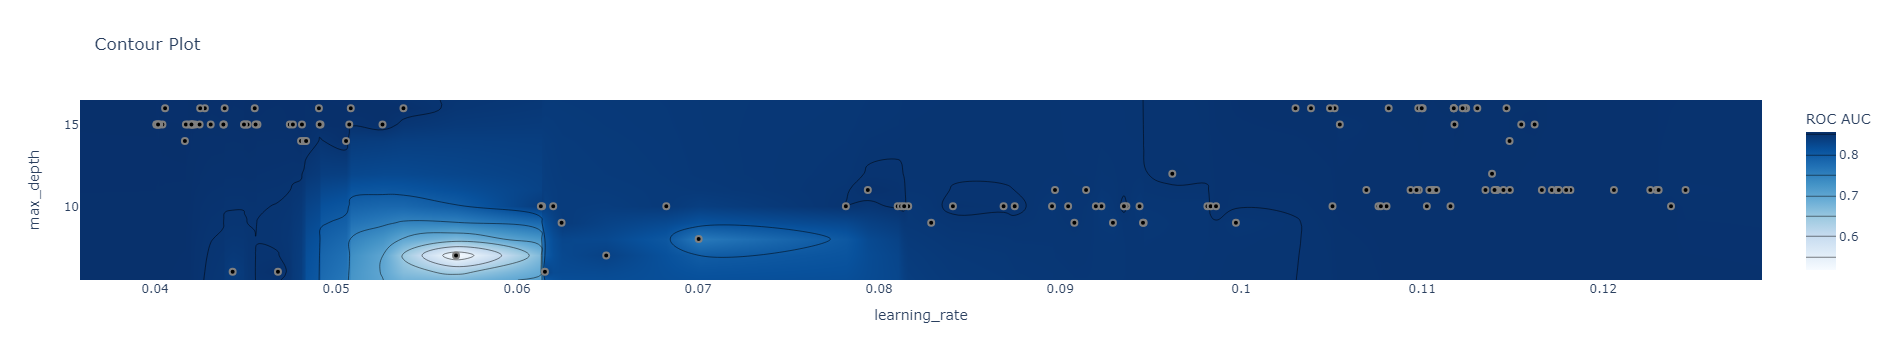

In [121]:
optuna.visualization.plot_contour(
    study, params=["learning_rate", "max_depth"], target_name="ROC AUC"
)

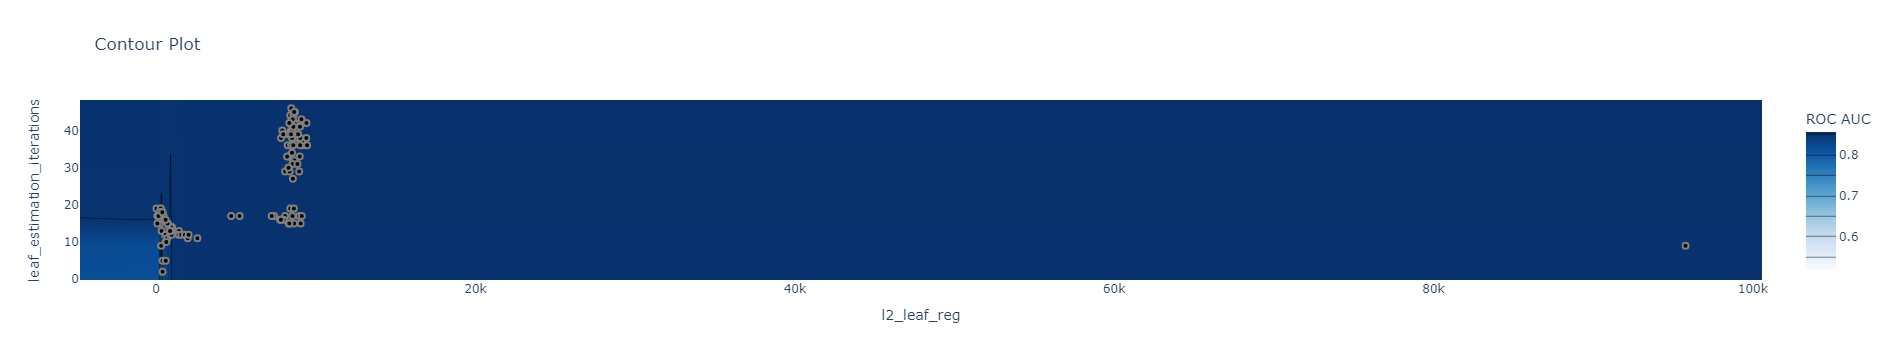

In [122]:
optuna.visualization.plot_contour(
    study, params=["l2_leaf_reg", "leaf_estimation_iterations"], target_name="ROC AUC"
)

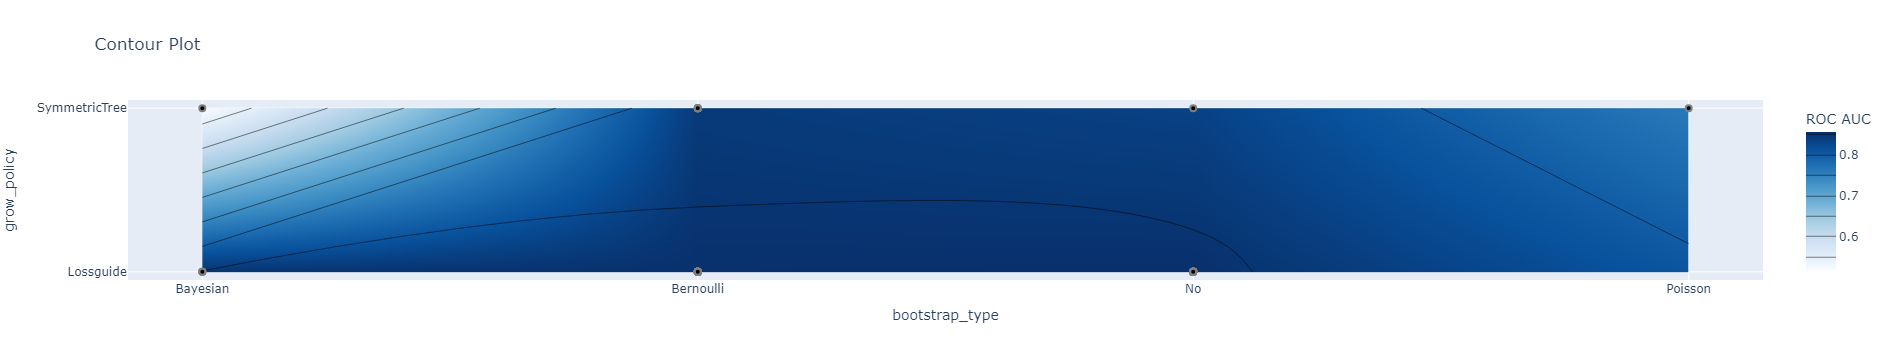

In [123]:
optuna.visualization.plot_contour(
    study, params=["bootstrap_type", "grow_policy"], target_name="ROC AUC"
)

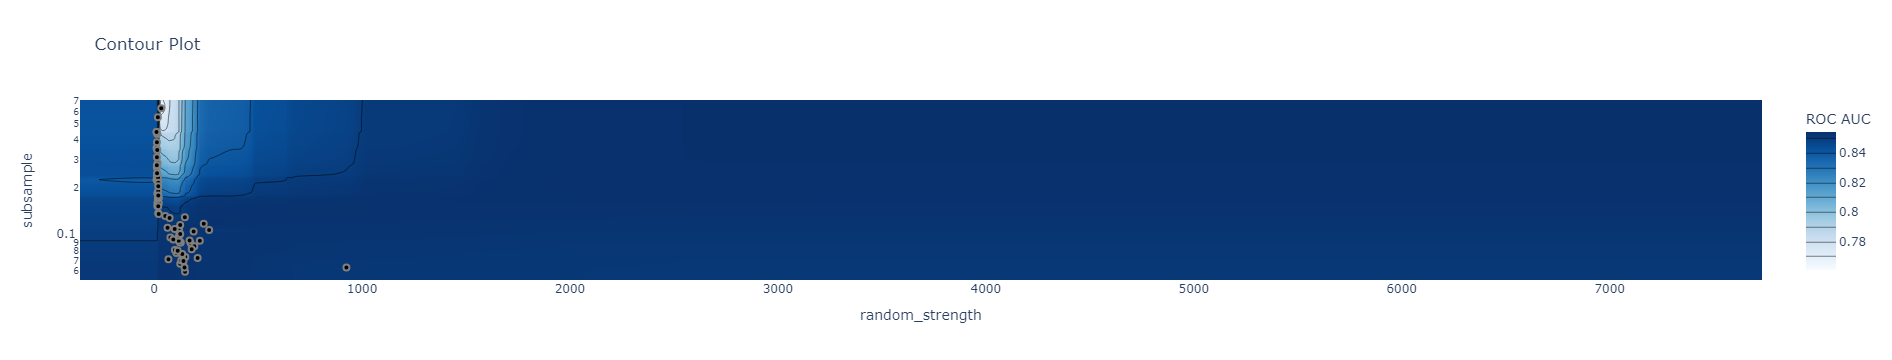

In [124]:
optuna.visualization.plot_contour(
    study, params=["random_strength", "subsample"], target_name="ROC AUC"
)

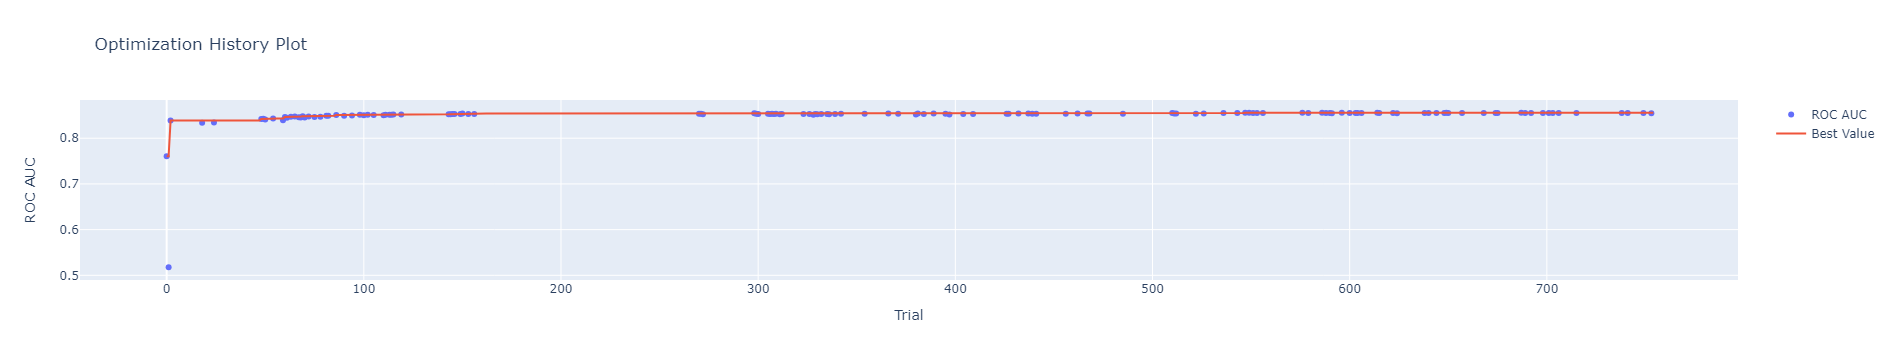

In [125]:
optuna.visualization.plot_optimization_history(study, target_name="ROC AUC")

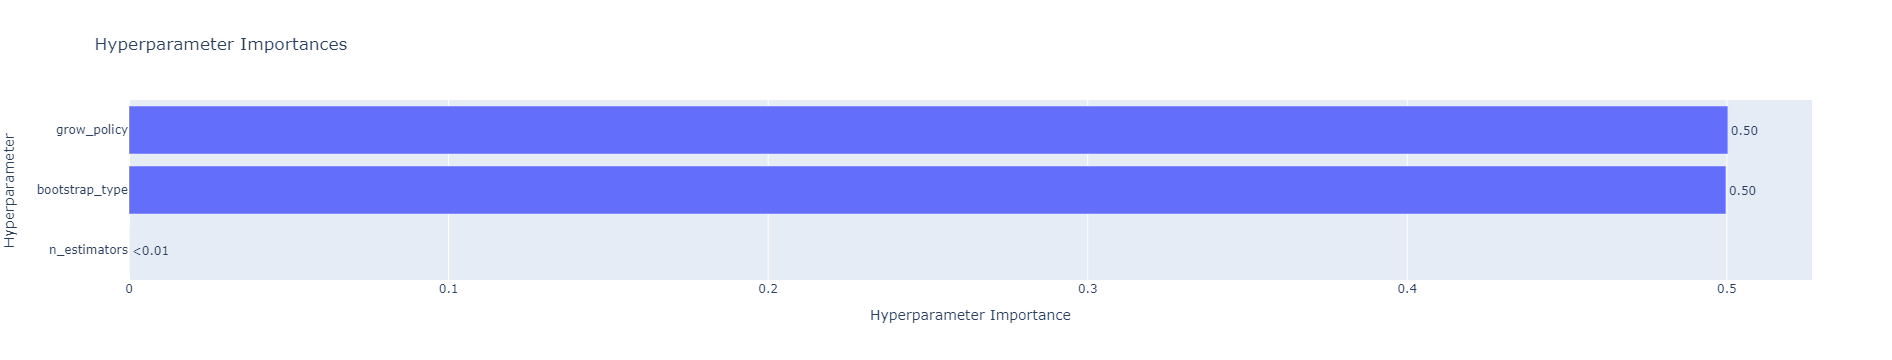

In [126]:
optuna.visualization.plot_param_importances(study)

In [ ]:
clf_opt = CatBoostClassifier(
    random_state=RAND,
    scale_pos_weight=scale_pos_weight,
    cat_features=cat_features,
    **study.best_params,
    **static_params_catboost
)

clf_opt.fit(X_train_, y_train_, eval_set=eval_set, early_stopping_rounds=100, verbose=0)

In [128]:
metrics_ = metrics_estimation(
    clf_opt,
    X_train_,
    y_train_,
    X_test,
    y_test,
    weeks_train_,
    weeks_test,
    name="CatBoost_Optuna",
)
metrics = pd.concat([metrics, metrics_])
metrics

Accuracy   ROC_AUC  Precision    Recall        f1  \
model                                                                        
CatBoost_Baseline_train  0.770459  0.874301   0.103364  0.821096  0.183614   
CatBoost_Baseline_test   0.769602  0.853037   0.098587  0.777164  0.174978   
CatBoost_Optuna_train    0.790753  0.905585   0.117845  0.872070  0.207632   
CatBoost_Optuna_test     0.785027  0.857266   0.103544  0.762371  0.182326   

                          Logloss  gini_stability  overfitting, %  
model                                                              
CatBoost_Baseline_train  0.460291        0.730205        2.492725  
CatBoost_Baseline_test   0.463039        0.674862        2.492725  
CatBoost_Optuna_train    0.414164        0.798161        5.636397  
CatBoost_Optuna_test     0.423469        0.689616        5.636397

Получилось улучшить целевую метрику gini stability на тестовых данных на 1.48 %. Но и переобучение увеличилось тоже на 3.1 %.

## RandomSearch

In [124]:
clf_gs = CatBoostClassifier(
    random_state=RAND,
    scale_pos_weight=scale_pos_weight,
    cat_features=cat_features,
    use_best_model=False,
    verbose=0,
    boosting_type="Plain",
    border_count=32,
    task_type="GPU",
    od_wait=20,
)

In [127]:
params_distribution = {
    "n_estimators": [100],
    "learning_rate": [0.04511161112013904],
    "depth": [14, 15, 16],
    "l2_leaf_reg": uniform(1, 1e4),
    "random_strength": uniform(1, 1e4),
    "bootstrap_type": ["Bayesian", "Bernoulli", "No", "Poisson"],
    "grow_policy": ["SymmetricTree", "Depthwise", "Lossguide"],
}

In [ ]:
grid_search_result = clf_gs.randomized_search(
    params_distribution, X_train, y_train, n_iter=100, verbose=0, plot=True
)

In [132]:
grid_search_result["params"]

{'grow_policy': 'Depthwise',
 'random_strength': 6702.421881190205,
 'depth': 14,
 'bootstrap_type': 'No',
 'learning_rate': 0.04511161112013904,
 'l2_leaf_reg': 6805.523936426123,
 'iterations': 2000}

In [ ]:
clf_rs = CatBoostClassifier(
    random_state=RAND,
    scale_pos_weight=scale_pos_weight,
    cat_features=cat_features,
    **grid_search_result["params"],
    **static_params_catboost
)

clf_rs.fit(X_train_, y_train_, eval_set=eval_set, early_stopping_rounds=100, verbose=0)

In [139]:
metrics_ = metrics_estimation(
    clf_rs,
    X_train_,
    y_train_,
    X_test,
    y_test,
    weeks_train_,
    weeks_test,
    name="CatBoost_RandomSearch",
)
metrics = pd.concat([metrics, metrics_])
metrics

Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
CatBoost_Baseline_train      0.770459  0.874301   0.103364  0.821096   
CatBoost_Baseline_test       0.769602  0.853037   0.098587  0.777164   
CatBoost_Optuna_train        0.790753  0.905585   0.117845  0.872070   
CatBoost_Optuna_test         0.785027  0.857266   0.103544  0.762371   
CatBoost_RandomSearch_train  0.856411  0.958871   0.171653  0.932500   
CatBoost_RandomSearch_test   0.837885  0.851337   0.120694  0.661319   

                                   f1   Logloss  gini_stability  \
model                                                             
CatBoost_Baseline_train      0.183614  0.460291        0.730205   
CatBoost_Baseline_test       0.174978  0.463039        0.674862   
CatBoost_Optuna_train        0.207632  0.414164        0.798161   
CatBoost_Optuna_test         0.182326  0.423469        0.689616   
CatBoost_RandomSearch_train  0.289935  0.332590        0.910057   
CatBoost_RandomSearch_test   0.204132  0.355608        0.676986   

                             overfitting, %  
model                                        
CatBoost_Baseline_train            2.492725  
CatBoost_Baseline_test             2.492725  
CatBoost_Optuna_train              5.636397  
CatBoost_Optuna_test               5.636397  
CatBoost_RandomSearch_train       12.631087  
CatBoost_RandomSearch_test        12.631087

Поиск значений гиперпараметров с помощью randomsearch не дал результатов лучше чем baseline.

# LightGBM

## Baseline

In [35]:
lgb_baseline = LGBMClassifier(
    random_state=RAND, scale_pos_weight=scale_pos_weight, n_jobs=24, verbose=0
)

In [ ]:
lgb_baseline.fit(
    X_train_,
    y_train_,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=100),
    ],
)

In [140]:
metrics_ = metrics_estimation(
    lgb_baseline,
    X_train_,
    y_train_,
    X_test,
    y_test,
    weeks_train_,
    weeks_test,
    name="LightGBM_Baseline",
)
metrics = pd.concat([metrics, metrics_])
metrics

Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
CatBoost_Baseline_train      0.770459  0.874301   0.103364  0.821096   
CatBoost_Baseline_test       0.769602  0.853037   0.098587  0.777164   
CatBoost_Optuna_train        0.790753  0.905585   0.117845  0.872070   
CatBoost_Optuna_test         0.785027  0.857266   0.103544  0.762371   
CatBoost_RandomSearch_train  0.856411  0.958871   0.171653  0.932500   
CatBoost_RandomSearch_test   0.837885  0.851337   0.120694  0.661319   
LightGBM_Baseline_train      0.775060  0.896789   0.109930  0.867326   
LightGBM_Baseline_test       0.766949  0.824493   0.091529  0.718512   

                                   f1   Logloss  gini_stability  \
model                                                             
CatBoost_Baseline_train      0.183614  0.460291        0.730205   
CatBoost_Baseline_test       0.174978  0.463039        0.674862   
CatBoost_Optuna_train        0.207632  0.414164        0.798161   
CatBoost_Optuna_test         0.182326  0.423469        0.689616   
CatBoost_RandomSearch_train  0.289935  0.332590        0.910057   
CatBoost_RandomSearch_test   0.204132  0.355608        0.676986   
LightGBM_Baseline_train      0.195128  0.435288        0.777927   
LightGBM_Baseline_test       0.162374  0.446039        0.619085   

                             overfitting, %  
model                                        
CatBoost_Baseline_train            2.492725  
CatBoost_Baseline_test             2.492725  
CatBoost_Optuna_train              5.636397  
CatBoost_Optuna_test               5.636397  
CatBoost_RandomSearch_train       12.631087  
CatBoost_RandomSearch_test        12.631087  
LightGBM_Baseline_train            8.768459  
LightGBM_Baseline_test             8.768459

## Optuna

In [39]:
def objective_lgbm(
    trial: optuna.trial.Trial, X: pd.DataFrame, y: pd.Series, weeks: pd.Series
) -> float:
    """
    Optimization objective function for LightGBM model with cross-validation.

    Parameters
    ----------
    trial : optuna.trial.Trial
       instance represents a process of evaluating an objective function
    X: pd.DataFrame
        X_train to split into X_train_cv and X_val_cv
    y: pd.Series
        y_train to split into y_train_cv and y_val_cv
    weeks: pd.Series
        For StratifiedGroupKFold as groups

    Returns
    -------
    out : float
       mean ROC_AUC
    """
    lgb_params = {        
        "n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 2000, step=20),
        "max_depth": trial.suggest_int("max_depth", 12, 16),
        "min_child_samples": trial.suggest_int(
            "min_child_samples", 100, 1000, step=100
        ),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 1e4),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 1e4),
        "min_split_gain": trial.suggest_int("min_split_gain", 0, 20),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "boosting": trial.suggest_categorical("boosting", ["gbdt", "rf", "dart"]),
    }

    cv = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True)
    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=weeks)):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
        model = LGBMClassifier(
            random_state=RAND,
            scale_pos_weight=scale_pos_weight,
            n_jobs=4,
            force_col_wise=True,
            verbose=-1,
            **lgb_params,
        )
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc')
        model.fit(
            X_train_cv,
            y_train_cv,
            eval_set=[(X_val_cv, y_val_cv)],
            eval_metric="auc",
            callbacks=[early_stopping(stopping_rounds=50, verbose=0), pruning_callback],
        )

        y_pred = model.predict(X_val_cv)
        y_score = model.predict_proba(X_val_cv)
        cv_predicts[idx] = roc_auc_score(y_val_cv, y_score[:, 1])
        print(f"Fold {idx} ROC AUC = {cv_predicts[idx]:.4f}")

    av_auc = np.mean(cv_predicts)
    print(f"Average ROC AUC on validation data (OOF): {av_auc:.4f}")
    return av_auc

In [ ]:
gc.collect()

study_name = "lgbm21"
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(
    storage_name,
    study_name=study_name,
    direction="maximize",
    load_if_exists=True,
)

In [ ]:
func = lambda trial: objective_lgbm(trial, X_train, y_train, weeks_train)
n_trials = 1000 - len(study.trials)
study.optimize(
    func,
    n_trials=n_trials,
    show_progress_bar=True,
    n_jobs=6,
    gc_after_trial=True,
    timeout=n_trials * 1 * 5 * 60,
)

In [43]:
study.best_params

{'n_estimators': 100,
 'learning_rate': 0.1954073518029098,
 'num_leaves': 1060,
 'max_depth': 15,
 'min_child_samples': 1000,
 'reg_alpha': 540,
 'reg_lambda': 810,
 'min_split_gain': 0,
 'subsample': 0.2870356371135097,
 'colsample_bytree': 0.5485996287336528,
 'boosting': 'dart'}

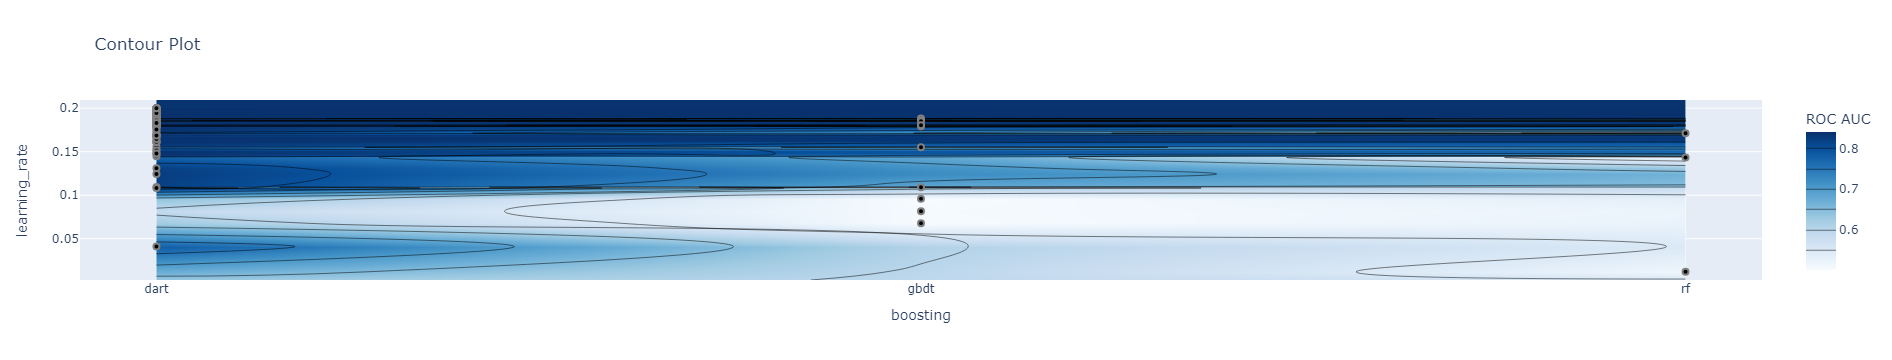

In [44]:
optuna.visualization.plot_contour(
    study, params=["learning_rate", "boosting"], target_name="ROC AUC"
)

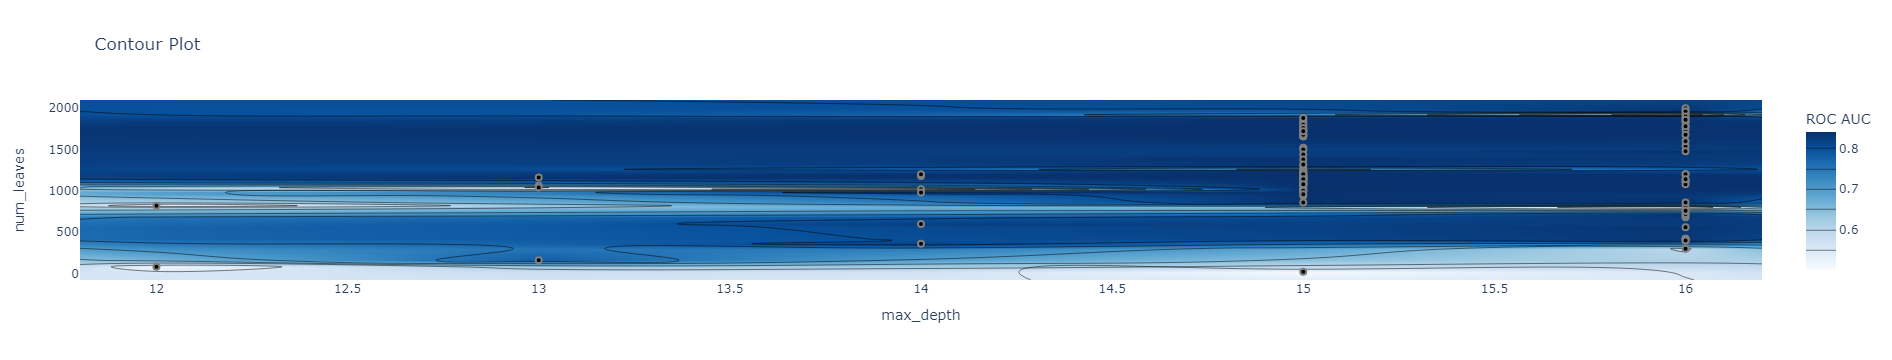

In [45]:
optuna.visualization.plot_contour(
    study, params=["num_leaves", "max_depth"], target_name="ROC AUC"
)

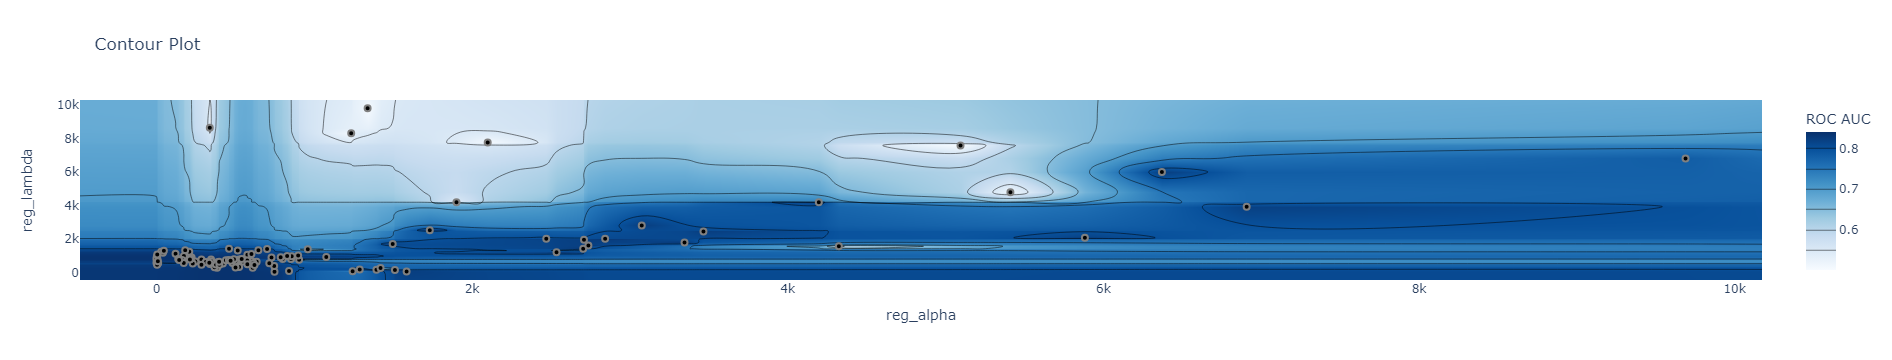

In [51]:
optuna.visualization.plot_contour(
    study, params=["reg_alpha", "reg_lambda"], target_name="ROC AUC"
)

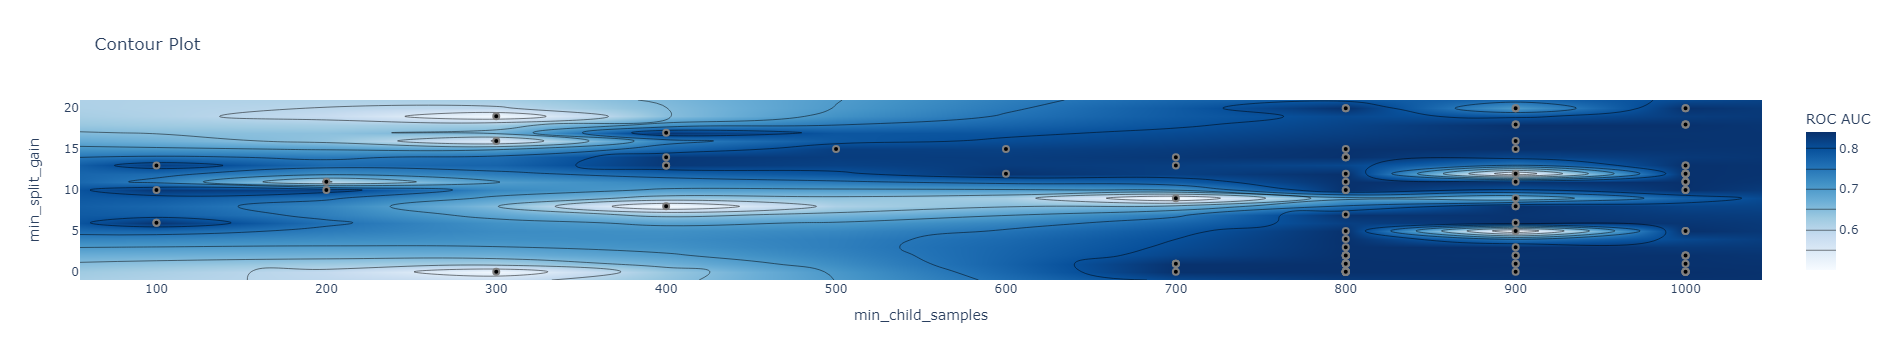

In [50]:
optuna.visualization.plot_contour(
    study, params=["min_child_samples", "min_split_gain"], target_name="ROC AUC"
)

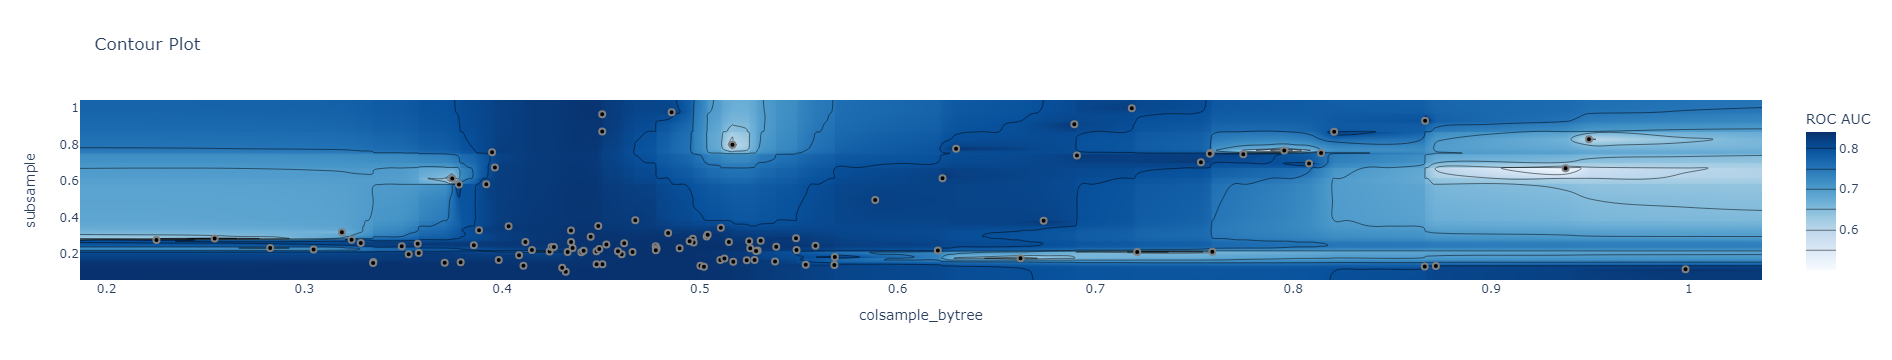

In [49]:
optuna.visualization.plot_contour(
    study, params=["subsample", "colsample_bytree"], target_name="ROC AUC"
)

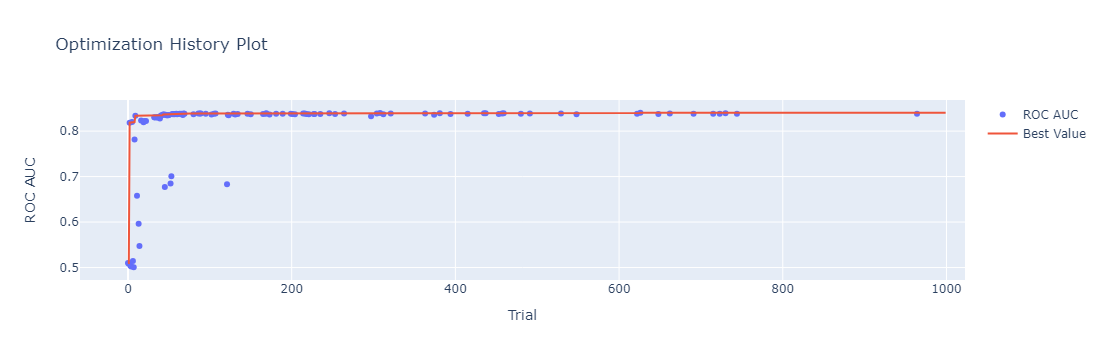

In [52]:
optuna.visualization.plot_optimization_history(study, target_name="ROC AUC")

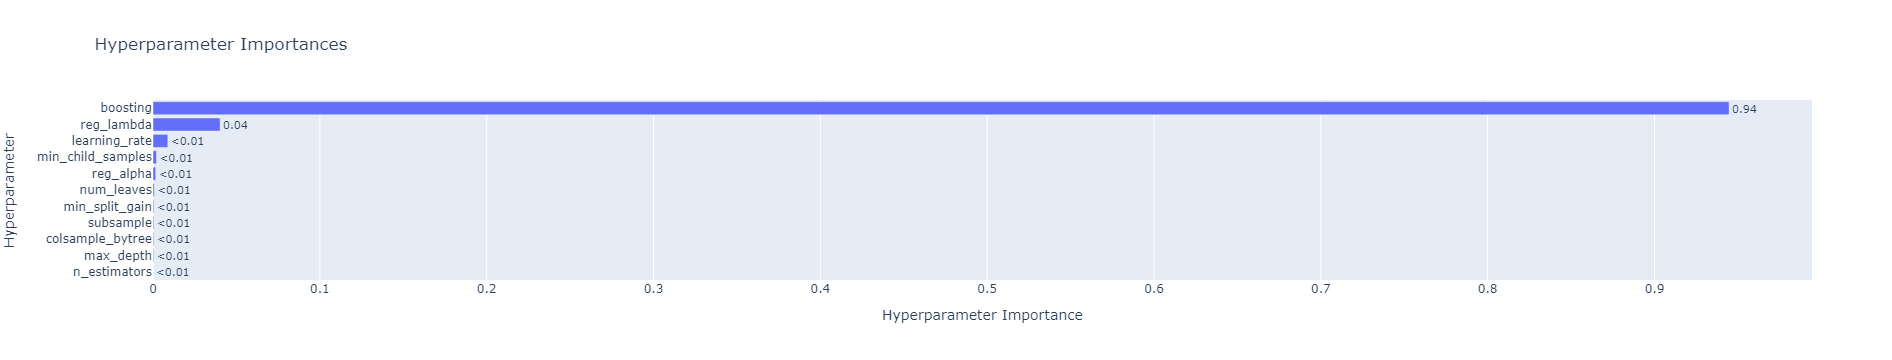

In [53]:
optuna.visualization.plot_param_importances(study)

In [54]:
lgb_opt = LGBMClassifier(
    random_state=RAND,
    scale_pos_weight=scale_pos_weight,
    n_jobs=24,
    verbose=0,
    **study.best_params,
)

In [ ]:
lgb_opt.fit(
    X_train_,
    y_train_,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=100, verbose=0),
    ],
)

In [ ]:
metrics_ = metrics_estimation(
    lgb_opt,
    X_train_,
    y_train_,
    X_test,
    y_test,
    weeks_train_,
    weeks_test,
    name="LightGBM_Optuna",
)
metrics = pd.concat([metrics, metrics_])

In [153]:
metrics

Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
CatBoost_Baseline_train      0.770459  0.874301   0.103364  0.821096   
CatBoost_Baseline_test       0.769602  0.853037   0.098587  0.777164   
CatBoost_Optuna_train        0.790753  0.905585   0.117845  0.872070   
CatBoost_Optuna_test         0.785027  0.857266   0.103544  0.762371   
CatBoost_RandomSearch_train  0.856411  0.958871   0.171653  0.932500   
CatBoost_RandomSearch_test   0.837885  0.851337   0.120694  0.661319   
LightGBM_Baseline_train      0.775060  0.896789   0.109930  0.867326   
LightGBM_Baseline_test       0.766949  0.824493   0.091529  0.718512   
LightGBM_Optuna_train        0.783019  0.894462   0.112573  0.857466   
LightGBM_Optuna_test         0.778209  0.848614   0.099877  0.755704   

                                   f1   Logloss  gini_stability  \
model                                                             
CatBoost_Baseline_train      0.183614  0.460291        0.730205   
CatBoost_Baseline_test       0.174978  0.463039        0.674862   
CatBoost_Optuna_train        0.207632  0.414164        0.798161   
CatBoost_Optuna_test         0.182326  0.423469        0.689616   
CatBoost_RandomSearch_train  0.289935  0.332590        0.910057   
CatBoost_RandomSearch_test   0.204132  0.355608        0.676986   
LightGBM_Baseline_train      0.195128  0.435288        0.777927   
LightGBM_Baseline_test       0.162374  0.446039        0.619085   
LightGBM_Optuna_train        0.199018  0.429718        0.775124   
LightGBM_Optuna_test         0.176436  0.438048        0.663997   

                             overfitting, %  
model                                        
CatBoost_Baseline_train            2.492725  
CatBoost_Baseline_test             2.492725  
CatBoost_Optuna_train              5.636397  
CatBoost_Optuna_test               5.636397  
CatBoost_RandomSearch_train       12.631087  
CatBoost_RandomSearch_test        12.631087  
LightGBM_Baseline_train            8.768459  
LightGBM_Baseline_test             8.768459  
LightGBM_Optuna_train              5.402651  
LightGBM_Optuna_test               5.402651

Получилось улучшить значение gini_stability на 4.5 % для LightGBM.

# XGBoost

## Baseline

In [154]:
xgb_baseline = XGBClassifier(
    eval_metric="auc",
    early_stopping_rounds=100,
    random_state=RAND,
    scale_pos_weight=scale_pos_weight,
    enable_categorical=True,
    device="cuda",
)

In [ ]:
xgb_baseline.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], verbose=0)

In [156]:
metrics_ = metrics_estimation(
    xgb_baseline,
    X_train_,
    y_train_,
    X_test,
    y_test,
    weeks_train_,
    weeks_test,
    name="XGBoost_Baseline",
)
metrics = pd.concat([metrics, metrics_])
metrics

Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
CatBoost_Baseline_train      0.770459  0.874301   0.103364  0.821096   
CatBoost_Baseline_test       0.769602  0.853037   0.098587  0.777164   
CatBoost_Optuna_train        0.790753  0.905585   0.117845  0.872070   
CatBoost_Optuna_test         0.785027  0.857266   0.103544  0.762371   
CatBoost_RandomSearch_train  0.856411  0.958871   0.171653  0.932500   
CatBoost_RandomSearch_test   0.837885  0.851337   0.120694  0.661319   
LightGBM_Baseline_train      0.775060  0.896789   0.109930  0.867326   
LightGBM_Baseline_test       0.766949  0.824493   0.091529  0.718512   
LightGBM_Optuna_train        0.783019  0.894462   0.112573  0.857466   
LightGBM_Optuna_test         0.778209  0.848614   0.099877  0.755704   
XGBoost_Baseline_train       0.801754  0.898543   0.119748  0.835483   
XGBoost_Baseline_test        0.789452  0.801622   0.092986  0.650797   

                                   f1   Logloss  gini_stability  \
model                                                             
CatBoost_Baseline_train      0.183614  0.460291        0.730205   
CatBoost_Baseline_test       0.174978  0.463039        0.674862   
CatBoost_Optuna_train        0.207632  0.414164        0.798161   
CatBoost_Optuna_test         0.182326  0.423469        0.689616   
CatBoost_RandomSearch_train  0.289935  0.332590        0.910057   
CatBoost_RandomSearch_test   0.204132  0.355608        0.676986   
LightGBM_Baseline_train      0.195128  0.435288        0.777927   
LightGBM_Baseline_test       0.162374  0.446039        0.619085   
LightGBM_Optuna_train        0.199018  0.429718        0.775124   
LightGBM_Optuna_test         0.176436  0.438048        0.663997   
XGBoost_Baseline_train       0.209472  0.432290        0.772090   
XGBoost_Baseline_test        0.162723  0.447085        0.575426   

                             overfitting, %  
model                                        
CatBoost_Baseline_train            2.492725  
CatBoost_Baseline_test             2.492725  
CatBoost_Optuna_train              5.636397  
CatBoost_Optuna_test               5.636397  
CatBoost_RandomSearch_train       12.631087  
CatBoost_RandomSearch_test        12.631087  
LightGBM_Baseline_train            8.768459  
LightGBM_Baseline_test             8.768459  
LightGBM_Optuna_train              5.402651  
LightGBM_Optuna_test               5.402651  
XGBoost_Baseline_train            12.090518  
XGBoost_Baseline_test             12.090518

## Optuna

In [96]:
def objective_xgb(
    trial: optuna.trial.Trial, X: pd.DataFrame, y: pd.Series, weeks: pd.Series
) -> float:
    """
    Optimization objective function for XGBoost model with cross-validation.

    Parameters
    ----------
    trial : optuna.trial.Trial
       instance represents a process of evaluating an objective function
    X: pd.DataFrame
        X_train to split into X_train_cv and X_val_cv
    y: pd.Series
        y_train to split into y_train_cv and y_val_cv
    weeks: pd.Series
        For StratifiedGroupKFold as groups

    Returns
    -------
    out : float
       mean ROC_AUC
    """
    xgb_params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05),
        "max_depth": trial.suggest_int("max_depth", 6, 16),
        "gamma": trial.suggest_int("gamma", 0, 15),
        "min_child_weight": trial.suggest_int("min_child_weight", 4, 16),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1e4, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 1e2, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.1, 1.0),
    }

    cv = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True)
    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=weeks)):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
        pruning_callback = optuna.integration.XGBoostPruningCallback(
            trial, "validation_0-auc"
        )
        model = XGBClassifier(
            n_estimators=2000,
            eval_metric="auc",
            early_stopping_rounds=50,
            random_state=RAND,
            scale_pos_weight=scale_pos_weight,
            enable_categorical=True,
            device="cuda",
            callbacks=[pruning_callback],
            **xgb_params,
        )
        model.fit(
            X_train_cv,
            y_train_cv,
            eval_set=[(X_val_cv, y_val_cv)],
            verbose=0,
        )
        y_pred = model.predict(X_val_cv)
        y_score = model.predict_proba(X_val_cv)
        cv_predicts[idx] = roc_auc_score(y_val_cv, y_score[:, 1])
        print(f"Fold {idx} ROC AUC = {cv_predicts[idx]:.4f}")

    av_auc = np.mean(cv_predicts)
    print(f"Average ROC AUC on validation data (OOF): {av_auc:.4f}")
    return av_auc

In [ ]:
gc.collect()

study_name = "xgb12"
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(
    storage_name,
    study_name=study_name,
    direction="maximize",
    load_if_exists=True,
)

In [ ]:
func = lambda trial: objective_xgb(trial, X_train, y_train, weeks_train)
n_trials = 200 - len(study.trials)
study.optimize(
    func,
    n_trials=n_trials,
    show_progress_bar=True,
    n_jobs=1,
    gc_after_trial=True,
    timeout=n_trials * 1 * 5 * 60,
)

In [158]:
study.best_params

{'learning_rate': 0.030200548141930312,
 'max_depth': 6,
 'gamma': 2,
 'min_child_weight': 5,
 'reg_alpha': 571.8297282403511,
 'reg_lambda': 2.029865967114385,
 'subsample': 0.6465975244731151,
 'colsample_bytree': 0.963466000130137,
 'colsample_bylevel': 0.2682056222912268,
 'colsample_bynode': 0.7786367353875768}

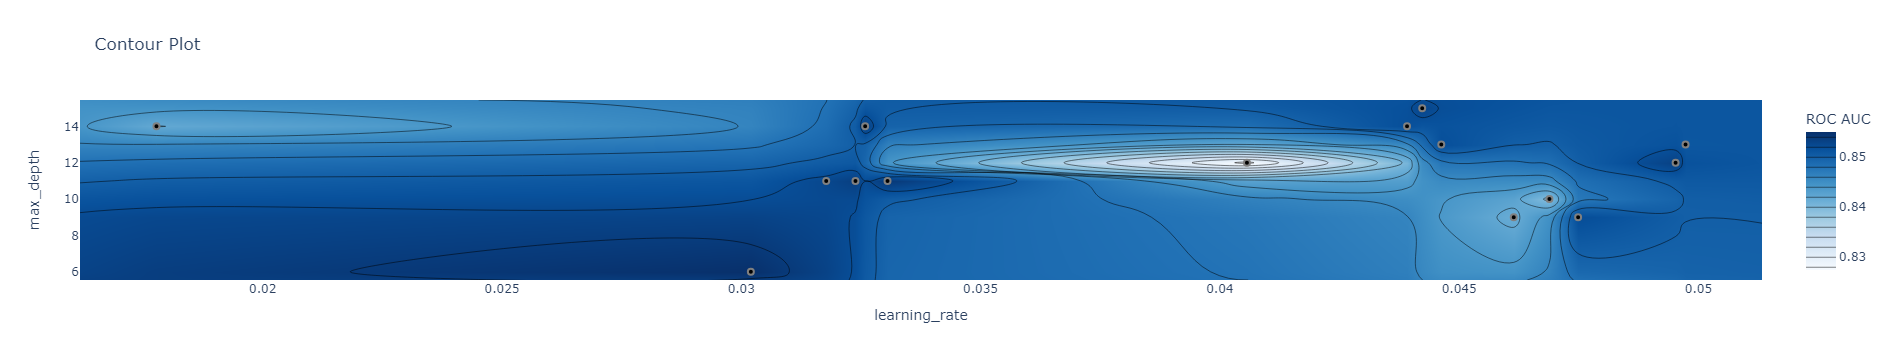

In [159]:
optuna.visualization.plot_contour(
    study, params=["learning_rate", "max_depth"], target_name="ROC AUC"
)

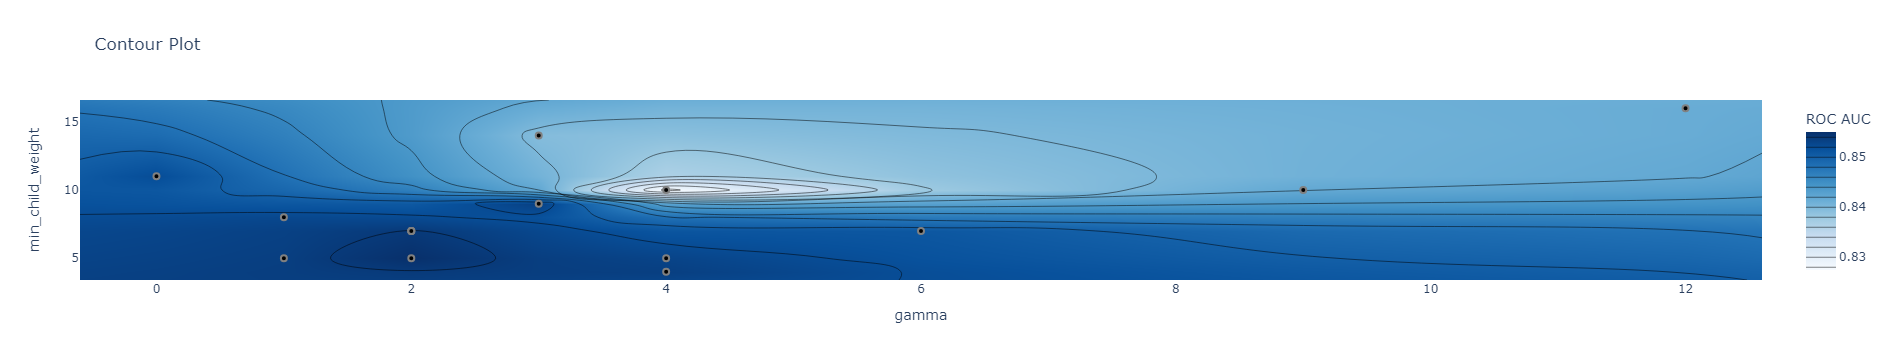

In [160]:
optuna.visualization.plot_contour(
    study, params=["gamma", "min_child_weight"], target_name="ROC AUC"
)

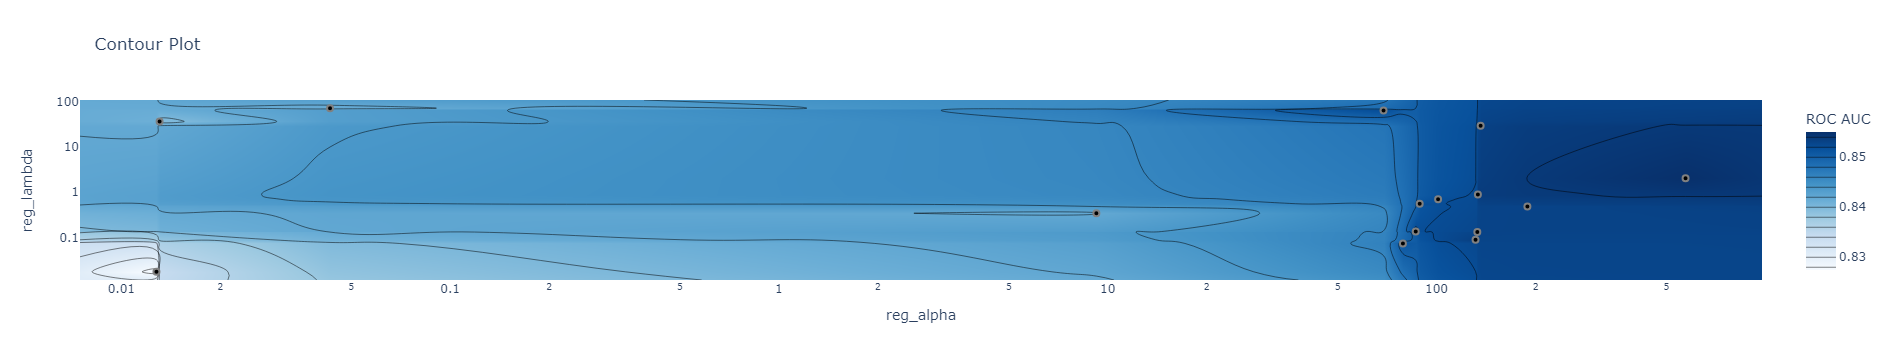

In [161]:
optuna.visualization.plot_contour(
    study, params=["reg_alpha", "reg_lambda"], target_name="ROC AUC"
)

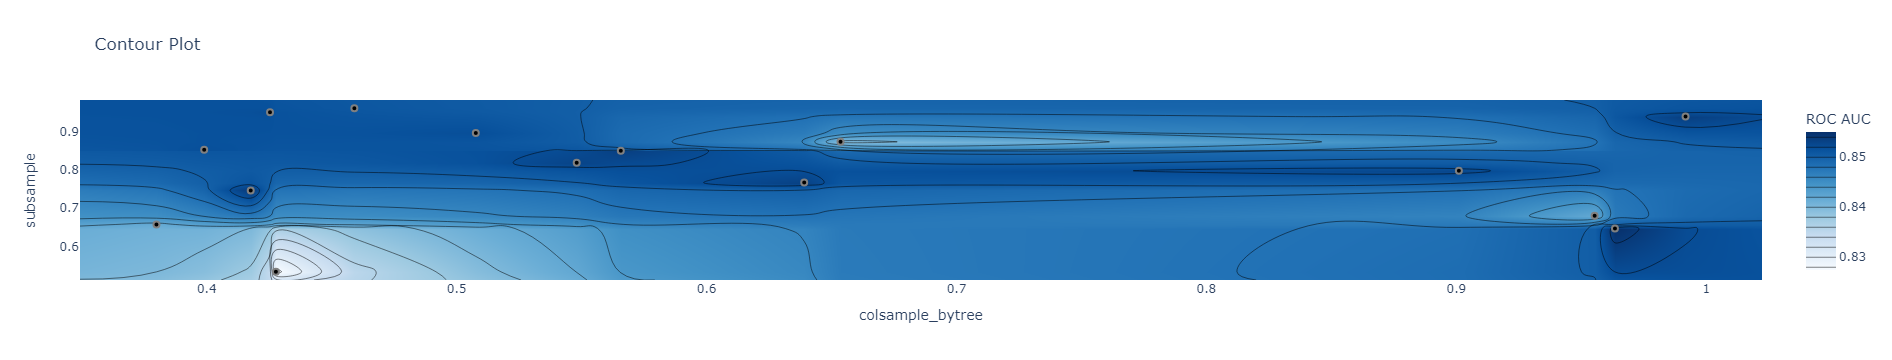

In [162]:
optuna.visualization.plot_contour(
    study, params=["subsample", "colsample_bytree"], target_name="ROC AUC"
)

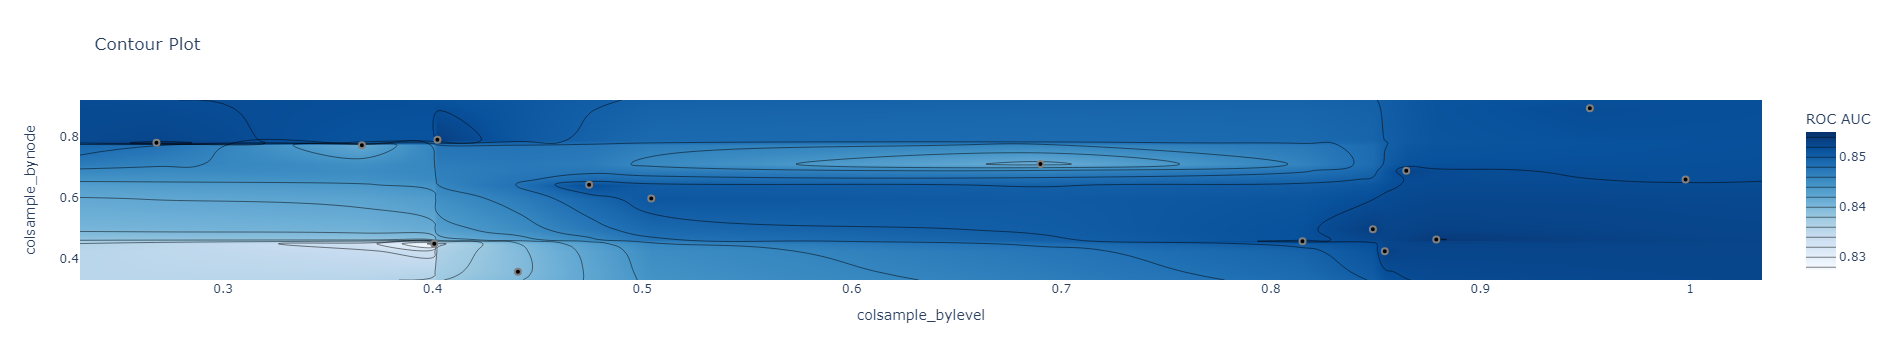

In [163]:
optuna.visualization.plot_contour(
    study, params=["colsample_bylevel", "colsample_bynode"], target_name="ROC AUC"
)

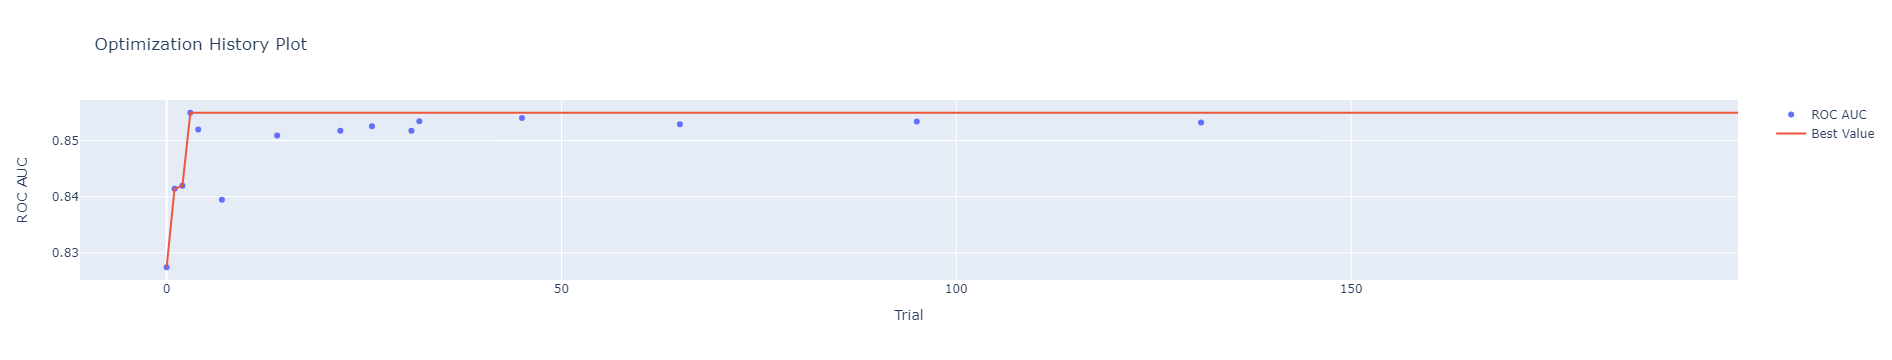

In [164]:
optuna.visualization.plot_optimization_history(study, target_name="ROC AUC")

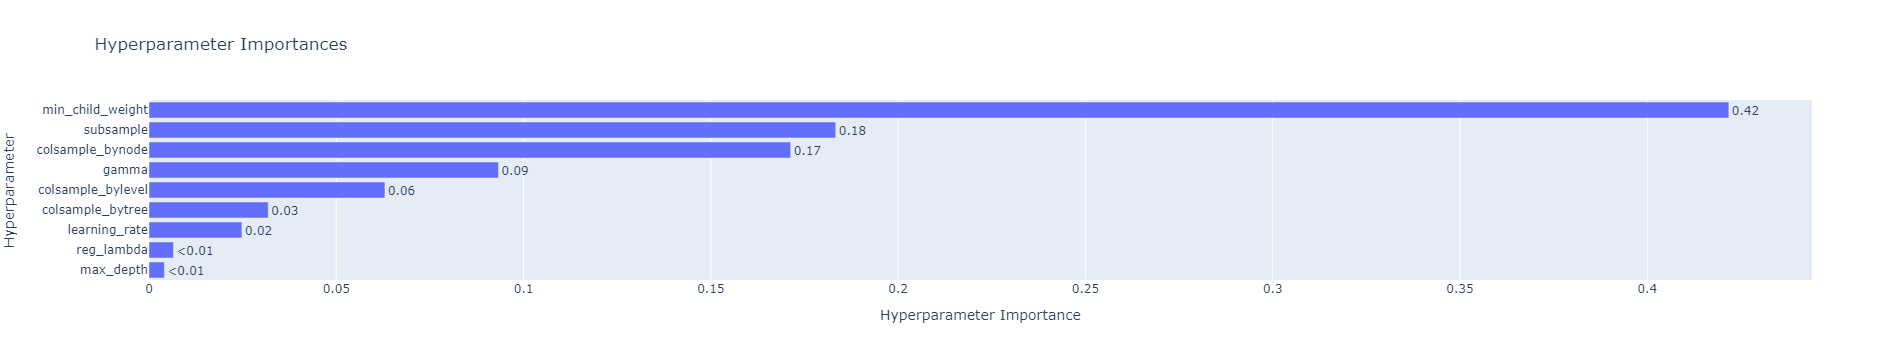

In [165]:
optuna.visualization.plot_param_importances(study)

In [ ]:
xgb_opt = XGBClassifier(
    eval_metric="auc",
    early_stopping_rounds=100,
    random_state=RAND,
    scale_pos_weight=scale_pos_weight,
    enable_categorical=True,
    device="cuda",
    **study.best_params
)
xgb_opt.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], verbose=0)

In [167]:
metrics_ = metrics_estimation(
    xgb_opt,
    X_train_,
    y_train_,
    X_test,
    y_test,
    weeks_train_,
    weeks_test,
    name="XGBoost_Optuna",
)
metrics = pd.concat([metrics, metrics_])
metrics

Accuracy   ROC_AUC  Precision    Recall  \
model                                                                  
CatBoost_Baseline_train      0.770459  0.874301   0.103364  0.821096   
CatBoost_Baseline_test       0.769602  0.853037   0.098587  0.777164   
CatBoost_Optuna_train        0.790753  0.905585   0.117845  0.872070   
CatBoost_Optuna_test         0.785027  0.857266   0.103544  0.762371   
CatBoost_RandomSearch_train  0.856411  0.958871   0.171653  0.932500   
CatBoost_RandomSearch_test   0.837885  0.851337   0.120694  0.661319   
LightGBM_Baseline_train      0.775060  0.896789   0.109930  0.867326   
LightGBM_Baseline_test       0.766949  0.824493   0.091529  0.718512   
LightGBM_Optuna_train        0.783019  0.894462   0.112573  0.857466   
LightGBM_Optuna_test         0.778209  0.848614   0.099877  0.755704   
XGBoost_Baseline_train       0.801754  0.898543   0.119748  0.835483   
XGBoost_Baseline_test        0.789452  0.801622   0.092986  0.650797   
XGBoost_Optuna_train         0.730878  0.829699   0.085375  0.778401   
XGBoost_Optuna_test          0.730936  0.821648   0.083873  0.761746   

                                   f1   Logloss  gini_stability  \
model                                                             
CatBoost_Baseline_train      0.183614  0.460291        0.730205   
CatBoost_Baseline_test       0.174978  0.463039        0.674862   
CatBoost_Optuna_train        0.207632  0.414164        0.798161   
CatBoost_Optuna_test         0.182326  0.423469        0.689616   
CatBoost_RandomSearch_train  0.289935  0.332590        0.910057   
CatBoost_RandomSearch_test   0.204132  0.355608        0.676986   
LightGBM_Baseline_train      0.195128  0.435288        0.777927   
LightGBM_Baseline_test       0.162374  0.446039        0.619085   
LightGBM_Optuna_train        0.199018  0.429718        0.775124   
LightGBM_Optuna_test         0.176436  0.438048        0.663997   
XGBoost_Baseline_train       0.209472  0.432290        0.772090   
XGBoost_Baseline_test        0.162723  0.447085        0.575426   
XGBoost_Optuna_train         0.153874  0.532857        0.636008   
XGBoost_Optuna_test          0.151109  0.532588        0.611196   

                             overfitting, %  
model                                        
CatBoost_Baseline_train            2.492725  
CatBoost_Baseline_test             2.492725  
CatBoost_Optuna_train              5.636397  
CatBoost_Optuna_test               5.636397  
CatBoost_RandomSearch_train       12.631087  
CatBoost_RandomSearch_test        12.631087  
LightGBM_Baseline_train            8.768459  
LightGBM_Baseline_test             8.768459  
LightGBM_Optuna_train              5.402651  
LightGBM_Optuna_test               5.402651  
XGBoost_Baseline_train            12.090518  
XGBoost_Baseline_test             12.090518  
XGBoost_Optuna_train               0.979784  
XGBoost_Optuna_test                0.979784

Получилось улучшить значение gini_stability на 3.6 % для XGBoost.

# Выводы

Для CatBoost получилось улучшить по сравнению с baseline значения целевой метрики gini stability на тестовых данных на 1.48 %. Для LightGBM на 4.5 %. Для XGBoost на 3.6 %. Далее будем использовать эти модели с лучшими параметрами и baseline модели в ансамблевых методах.